Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Linearni diskriminativni modeli

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **31. listopada 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od dva zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [7]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [8]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Točnost: 1.0
Težine:  [2.1, -0.5000000000000002, -0.09999999999999981]


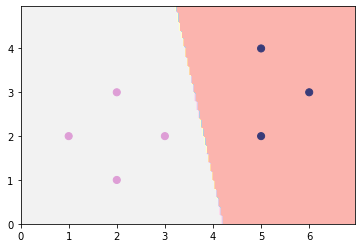

In [9]:
ridge_cls = RidgeClassifier(alpha=0)
ridge_cls.fit(seven_X, seven_y)
seven_y_pred = ridge_cls.predict(seven_X)

plot_2d_clf_problem(seven_X, seven_y, ridge_cls.predict)
print("Točnost:", accuracy_score(seven_y, seven_y_pred))

w = [ridge_cls.intercept_[0]]
w.extend(ridge_cls.coef_[0])
print("Težine: ", w)

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

Točnost: 1.0
Težine:  [1.5500000000000003, -0.25000000000000006, -0.050000000000000086]
Težine:  [2.100000000000001, -0.5000000000000001, -0.10000000000000017]


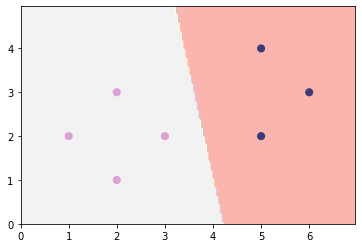

In [10]:
lin_reg = LinearRegression()
lin_reg.fit(seven_X, seven_y)

pred_fun = lambda x : lin_reg.predict(x) >= 0.5

seven_y_pred_lr = pred_fun(seven_X)
plot_2d_clf_problem(seven_X, seven_y, pred_fun)
print("Točnost:", accuracy_score(seven_y, seven_y_pred_lr))

w = [lin_reg.intercept_]
w.extend(lin_reg.coef_)
print("Težine: ", w)

# ako se nule preslikaju u -1
new_y = np.where(seven_y == 0, -1, 1)
lin_reg2 = LinearRegression().fit(seven_X, new_y)
pred_fun2 = lambda x : lin_reg2.predict(x) >= 0
w2 = [lin_reg2.intercept_]
w2.extend(lin_reg2.coef_)
print("Težine: ", w2)

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [11]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

Točnost: 0.875


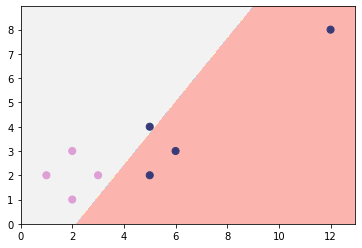

In [12]:
ridge_cls_ol = RidgeClassifier(alpha=0)
ridge_cls_ol.fit(outlier_X, outlier_y)
outlier_y_pred = ridge_cls_ol.predict(outlier_X)

plot_2d_clf_problem(outlier_X, outlier_y, ridge_cls_ol.predict)
print("Točnost:", accuracy_score(outlier_y, outlier_y_pred))

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [13]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

Točnost: 0.875


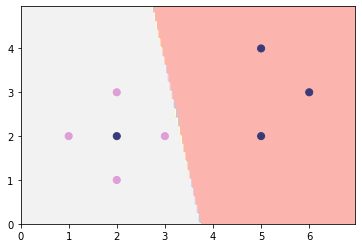

In [14]:
ridge_cls_us = RidgeClassifier(alpha=0)
ridge_cls_us.fit(unsep_X, unsep_y)
unsep_y_pred = ridge_cls_us.predict(unsep_X)

plot_2d_clf_problem(unsep_X, unsep_y, ridge_cls_us.predict)
print("Točnost:", accuracy_score(unsep_y, unsep_y_pred))

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

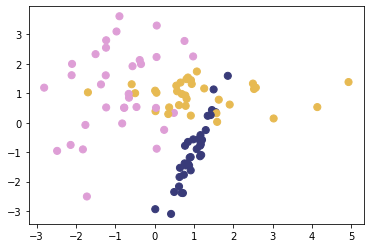

In [42]:
from sklearn.datasets import make_classification

X, y = make_classification(n_classes=3, n_features=2, n_redundant=0, n_clusters_per_class=1)
plot_2d_clf_problem(X, y)

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

In [43]:
def get_model(y):
    model = LinearRegression().fit(X, y)
    pred = lambda x: model.predict(x) >= 0.5
    return model, pred

In [44]:
def plot_binary(pred_fun, i):
    subplot(1, 3, i)
    plot_2d_clf_problem(X, y, pred_fun)
    plt.title(f'$h_{i}$')

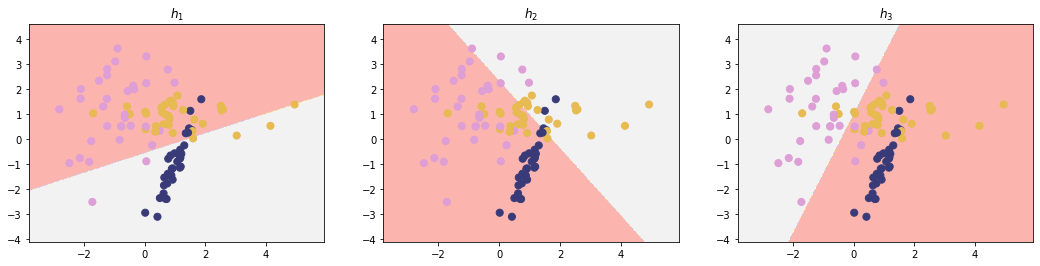

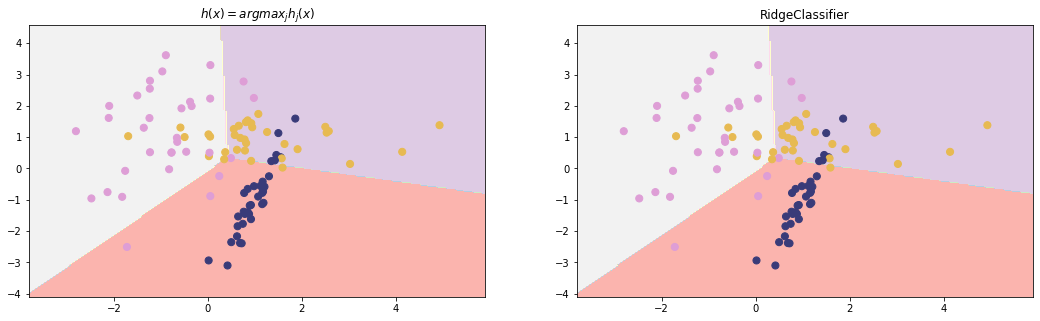

In [45]:
import copy
y1 = np.where(y == 0, 1, 0)
y2 = np.where(y == 1, 1, 0)
y3 = np.where(y == 2, 1, 0)

pred_funs = []

lin_reg_1, pred_fun_1 = get_model(y1)
lin_reg_2, pred_fun_2 = get_model(y2)
lin_reg_3, pred_fun_3 = get_model(y3)
pred_funs.append(pred_fun_1)
pred_funs.append(pred_fun_2)
pred_funs.append(pred_fun_3)

plt.figure(figsize=(18, 4))
for i, fun in enumerate(pred_funs, start=1):
    plot_binary(fun, i)

h_argmax = lambda x: argmax([lin_reg_1.predict([x]), lin_reg_2.predict([x]), lin_reg_3.predict([x])])

plt.figure(figsize=(18, 5))
subplot(1, 2, 1)
plot_2d_clf_problem(X, y, h_argmax)
plt.title('$h(x) = argmax_jh_j(x)$')


ridge_class = RidgeClassifier(alpha=0).fit(X, y)
pred_fun_ridge = lambda x: ridge_class.predict(x)
subplot(1, 2, 2)
plot_2d_clf_problem(X, y, pred_fun_ridge);
plt.title('RidgeClassifier');

plt.show()
